## Extrinsic calibration in `Real-world`

### Real-sense libraries

In [2]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import cv2

import json
import copy

import sys
sys.path.append("..")
from utils.utils_cali import *

### setup camera

Frames Captured: Clean image
Frames Captured: Yellowish image


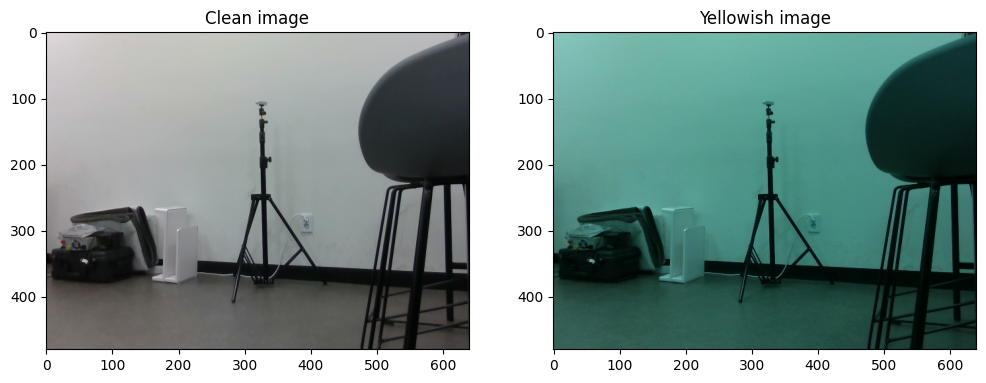

In [4]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt

# Setup:
pipe = rs.pipeline()
cfg = rs.config()
profile = pipe.start(cfg)

for x in range(100):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_image = frameset.get_color_frame()
depth_image = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured: Clean image")
rgb_image = np.asanyarray(rgb_image.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,2,1)
plt.title("Clean image")
plt.imshow(rgb_image)
# plt.show()

# Setup:
pipe = rs.pipeline()
cfg = rs.config()
profile = pipe.start(cfg)
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_image = frameset.get_color_frame()
depth_image = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured: Yellowish image")
rgb_image = np.asanyarray(rgb_image.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,2,2)
plt.title("Yellowish image")
plt.imshow(rgb_image)
plt.show()

In [6]:
# Setup:
pipe = rs.pipeline()
config = rs.config()

# setting pre-defined camera parameters.
jsonObj = json.load(open("../cam_setting.json"))
json_string= str(jsonObj).replace("'", '\"')

print("W: ", int(jsonObj["viewer"]['stream-width']))
print("H: ", int(jsonObj["viewer"]['stream-height']))
print("FPS: ", int(jsonObj["viewer"]['stream-fps']))

config.enable_stream(rs.stream.depth, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.z16, int(jsonObj["viewer"]['stream-fps']))
config.enable_stream(rs.stream.color, int(jsonObj["viewer"]['stream-width']), int(jsonObj["viewer"]['stream-height']), rs.format.bgr8, int(jsonObj["viewer"]['stream-fps']))

cfg = pipe.start(config)
# cfg = pipe.start() # Start pipeline and get the configuration it found

# prevent yellowish image
for x in range(100):
  pipe.wait_for_frames()

# profile = pipe.start(cfg)
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intrinsic_matrix = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics
# print(dir(cfg.get_device()))
depth_sensor = cfg.get_device().first_depth_sensor()        # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print(f"Depth Scale is: {depth_scale:.4f} m")

for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
rgb_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# filling depth imgage.
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)

hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(filtered_depth)

depth_image_unfilled = np.asanyarray(depth_frame.get_data())
depth_image_filled = np.asanyarray(filled_depth.get_data())
color_image = np.asanyarray(rgb_frame.get_data())

# clipping depth image.
zero_padding = 0
clipping_distance_in_meters = 2    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리
depth_clipped_unfilled = np.where((depth_image_unfilled > clipping_distance) | (depth_image_unfilled <= 0), zero_padding, depth_image_unfilled)
depth_clipped_filled = np.where((depth_image_filled > clipping_distance) | (depth_image_filled <= 0), zero_padding, depth_image_filled)

# 3D image estimation.
img_xyz_unfilled = compute_xyz(depth_image_unfilled, camera_info=intrinsic_matrix)
img_xyz_filled = compute_xyz(depth_image_filled, camera_info=intrinsic_matrix)
img_xyz_clipped_unfilled = compute_xyz(depth_clipped_unfilled, camera_info=intrinsic_matrix)
img_xyz_clipped_filled = compute_xyz(depth_clipped_filled, camera_info=intrinsic_matrix)

img_copy = copy.deepcopy(color_image)
T_april, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)


plt.figure(figsize=(25,4))
plt.subplot(1,5,1)
plt.title("Original Image")
plt.imshow(color_image)
# plt.show()

plt.subplot(1,5,2)
plt.title("Original Depth unfilled Image")
plt.imshow(depth_image_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,3)
plt.title("Original Depth filled Image")
plt.imshow(depth_image_filled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,4)
plt.title("Clipped Depth unfilled Image")
plt.imshow(depth_clipped_unfilled)
plt.colorbar()
# plt.show()

plt.subplot(1,5,5)
plt.title("Clipped Depth filled Image")
plt.imshow(depth_clipped_filled)
plt.colorbar()
plt.show()

# Cleanup:
pipe.stop()
print("Frames Captured")

W:  1280
H:  720
FPS:  30


RuntimeError: Couldn't resolve requests

In [ ]:
img_copy = copy.deepcopy(color_image)
get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)


### UR5 libraries

In [3]:
from kinematics.class_structure import *

file_name = "../../urdf/ur5e_onrobot.urdf"
chain = CHAIN(file_name=file_name, base_offset=[0.18,0,0.79], verbose=False)
chain.add_joi_to_robot()
chain.add_joi_to_robot()
chain.add_link_to_robot()

# chain.fk_chain(1)


In [4]:
import sys 
sys.path.append("..")
import cv2 
from get_rostopic import RealsenseD435i
import numpy as np 
import rospy 
import matplotlib.pyplot as plt 
from utils.utils_pcl import *
from utils.utils_pointcloud import * 
print("Done.")

import rospy 
import time 
import numpy as np 
import message_filters
from sensor_msgs.msg import JointState

class UR_Test():
    def __init__(self):
        self.tick = 0
        self.joint_list = None 
        self.joint_sub = rospy.Subscriber('/joint_states', JointState, self.joint_callback) 

        tic_temp=0 

        while self.tick<2: 
            time.sleep(1e-3)
            tic_temp=tic_temp+1

            if tic_temp>5000: 
                print ("[ERROR] GET JOINTS")
                break 
            
    def joint_callback(self, joint_msg):
        """
            Get joint values about each joint.
        """
        self.tick+=1 
        self.joint_list = joint_msg 

    # def fk_chain(self, idx_to):
    #     # self.joint_list = 
        
    #     if idx_to == 0:
    #         pass
    #     elif idx_to != 0:
    #         link_mother =  self.joint

    #     return 0

Done.


#### get `joint value` in real-time

In [15]:
rospy.init_node('test')
ur_test = UR_Test()

print(ur_test.joint_list.position)
joint_value = ur_test.joint_list.position   # tuple form
# joint_value_list = [joint_value[i] for i in range(len(joint_value))]    # list form
joint_value_list = list(joint_value)        # list form

q_list = [0]
q_list = q_list + joint_value_list
q_list

KeyboardInterrupt: 

### update q_chain

In [ ]:
def update_q_chain(robot_jc, q_list, ctrl_joint):
    for idx in range(len(robot_jc)):
        if idx < ctrl_joint:
            robot_jc[idx].q = q_list[idx]

ctrl_joint_num = 6

joint_value = ur_test.joint_list.position   # tuple form
# joint_value_list = [joint_value[i] for i in range(len(joint_value))]    # list form
joint_value_list = list(joint_value)        # list form

q_list = [0]
q_list = q_list + joint_value_list  # Sequential joint values: 7

# Update q_chain
update_q_chain(chain.joint, q_list, ctrl_joint_num)
chain.fk_chain(1)
p_list     = get_p_chain(chain.joint)
R_list     = get_R_chain(chain.joint)

print(p_list)
print(R_list)

##### forward kinematic

In [11]:
for i in range(len(q_list)):
    chain.joint[i].q = q_list[i]
    print(chain.joint[i].q)

# forward kinematics: correspond to each joint values.
chain.fk_chain(1)

p_eef = chain.joint[6].p
R_eef = chain.joint[6].R
print(p_eef)

T_eef = cv2.hconcat((R_eef, p_eef))
T_eef

-1.5701611677752894
-2.317308088342184
2.151837174092428
1.7310170370289306
0.7755656242370605
-1.5670517126666468
[[0.56532526]
 [0.21919682]
 [0.86782613]]


array([[-0.73419416, -0.03388267, -0.67809358,  0.56532526],
       [ 0.67892927, -0.04214009, -0.73299335,  0.21919682],
       [-0.00373915, -0.99853702,  0.05394295,  0.86782613]])

In [ ]:
R_cam_joint = chain.joint[len(joint_value)-1].R
p_cam_joint = chain.joint[len(joint_value)-1].p

T_cam_joint = cv2.hconcat((R_cam_joint, p_cam_joint))
T_cam_joint

In [42]:
chain.joint[9].name

'gripper_tcp_joint'

In [6]:
def get_homogeneous_matrix(chain, q_list, from_link='base_joint', to_link='gripper_tcp_joint', verbose=False):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about B that represents sequenced transformation operations on ['from link' to 'to link'].
        T^to_from = (T^from_world)^-1 @ T^to_world
    """
    for i in range(len(q_list)):
        chain.joint[i].q = q_list[i]
        print(chain.joint[i].q)

    # forward kinematics: correspond to each joint values.
    chain.fk_chain(1)
    
    p_eef = chain.joint[len(q_list)-1].p
    R_eef = chain.joint[len(q_list)-1].R

    for i in range(10):
        # if ("base_joint") in chain.joint[i].name:
        if chain.joint[i].name[:len(from_link)]==from_link:
            print(i)
            print(chain.joint[i].name)
            p_from_link = chain.joint[i].p
            R_from_link = chain.joint[i].R
            T_from_link = cv2.hconcat((R_from_link, p_from_link))      # 3x4
            T_from_link = np.vstack((T_from_link, np.array([0,0,0,1])))   # 4x4

        elif chain.joint[i].name[:len(to_link)]==to_link:
            print(i)
            print(chain.joint[i].name)
            p_to_link = chain.joint[i].p
            R_to_link = chain.joint[i].R
            T_to_link = cv2.hconcat((R_to_link, p_to_link))      # 3x4
            T_to_link = np.vstack((T_to_link, np.array([0,0,0,1])))   # 4x4
    
    # Homogeneous matrix 'from link' to 'to link'
    p_from_inv = -np.linalg.inv(R_from_link) @ p_from_link
    R_from_inv = np.linalg.inv(R_from_link)
    T_from_inv = cv2.hconcat((R_from_inv, p_from_inv))      # 3x4
    T_from_inv = np.vstack((T_from_inv, np.array([0,0,0,1])))   # 4x4

    T_from2to = T_from_inv @ T_to_link

    if verbose:
        print(f"Transformation matrix about 'from link': {from_link}")
        print(T_from_link)
        print(f"Transformation matrix about 'to link': {to_link}")
        print(T_to_link)
        print(f"Transformation matrix about 'from2to' link: {from_link} -> {to_link}")
        print(T_from2to)

    return T_from2to

init_configurations = [-math.pi/2, -math.pi/2, 0, 0, 0, 0]
init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2]


q_list = [0, 0, 0, 3.14, 0, 3.14, 0]
print(q_list[0])
bs2ee_matrix = get_homogeneous_matrix(chain, init_configurations, from_link='base_joint', to_link='gripper_tcp_joint', verbose=True)

0
-1.5707963267948966
-2.356194490192345
2.356194490192345
1.5707963267948966
0.7853981633974483
-1.5707963267948966
0
base_joint
9
gripper_tcp_joint
Transformation matrix about 'from link': base_joint
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'to link': gripper_tcp_joint
[[-7.07106781e-01  7.07106557e-01 -5.63088024e-04  6.12445906e-01]
 [ 7.07106781e-01  7.07106557e-01 -5.63088024e-04  2.42941288e-01]
 [-1.11022302e-16 -7.96326721e-04 -9.99999683e-01  6.59665530e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Transformation matrix about 'from2to' link: base_joint -> gripper_tcp_joint
[[-7.07106781e-01  7.07106557e-01 -5.63088024e-04  4.32445906e-01]
 [ 7.07106781e-01  7.07106557e-01 -5.63088024e-04  2.42941288e-01]
 [-1.11022302e-16 -7.96326721e-04 -9.99999683e-01 -1.30334470e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### calibration part

In [59]:
# extrinsic calibration using cv2.calibrateHandEye()
def get_extrinsic_calibration(img, img_depth, from_link='base_joint', to_link='gripper_tcp_joint'):
    # Get matrix A.
    # Transformation matrix about 'camera to target'.
    tagpose, img_pose = get_apriltag_pose(img, img_depth, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)
    R_cam2target = tagpose[:3, :3]
    p_cam2target = tagpose[:3, 3]

    # inverse of T_cam2target matrix
    p_target2cam = -np.linalg.inv(R_cam2target) @ p_cam2target
    R_target2cam = np.linalg.inv(R_cam2target)

    # Get matrix B.
    # Transformation matrix about 'ee to base'.
    T_ee2bs = get_homogeneous_matrix(chain, q_list, from_link='base_joint', to_link='gripper_tcp_joint', verbose=True)
    R_ee2bs = T_ee2bs[:3, :3]
    p_ee2bs = T_ee2bs[:3, 3]

    R_ext, p_ext = cv2.calibrateHandEye(R_ee2bs, p_ee2bs, R_target2cam, p_target2cam, method=cv2.CALIB_HAND_EYE_TSAI)

    T_extrinsic = cv2.hconcat((R_ext, p_ext))      # 3x4
    T_extrinsic = np.vstack((T_extrinsic, np.array([0,0,0,1])))   # 4x4

    return T_extrinsic

T_april, img_pose = get_apriltag_pose(img_copy, depth_image_unfilled, intrinsic_matrix=intrinsic_matrix, tag_size=0.008, verbose_bbox=False, verbose_pose=True)

get_extrinsic_calibration(img_copy, depth_image_unfilled, from_link='base_joint', to_link='gripper_tcp_joint')

NameError: name 'depth_image_unfilled' is not defined

In [8]:
from utils.utils_cali import *

In [10]:
p_from_link = chain.joint[0].p
R_from_link = chain.joint[0].R
T_from_link = cv2.hconcat((R_from_link, p_from_link))      # 3x4
T_from_link = np.vstack((T_from_link, np.array([0,0,0,1])))   # 4x4

p_to_link = chain.joint[9].p
R_to_link = chain.joint[9].R
T_to_link = cv2.hconcat((R_to_link, p_to_link))      # 3x4
T_to_link = np.vstack((T_to_link, np.array([0,0,0,1])))   # 4x4

In [16]:
T_from_link

array([[1.  , 0.  , 0.  , 0.18],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.79],
       [0.  , 0.  , 0.  , 1.  ]])

In [17]:
T_to_link

array([[-7.07106781e-01,  7.07106557e-01, -5.63088024e-04,
         6.12445906e-01],
       [ 7.07106781e-01,  7.07106557e-01, -5.63088024e-04,
         2.42941288e-01],
       [-1.11022302e-16, -7.96326721e-04, -9.99999683e-01,
         6.59665530e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [12]:
T_ext_frank = get_extrinsic_calibration_frank([T_from_link], [T_to_link])
T_ext_frank

LinAlgError: Singular matrix

In [14]:
T_ext_tsai = get_extrinsic_calibration_tsai([T_from_link], [T_to_link])
T_ext_tsai

array([[ 1.00000000e+00,  2.22042451e-16, -5.46148471e-18,
         0.00000000e+00],
       [-2.22042451e-16,  1.00000000e+00, -1.29717518e-17,
         0.00000000e+00],
       [ 5.46148471e-18,  1.29717518e-17,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

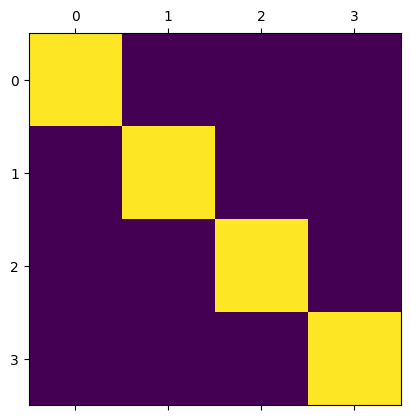

In [15]:
plt.matshow(T_ext_tsai)